# CAB420, Week 4 Practical, Question 1 Solution
## Kuzushiji-MNIST and Kuzushiji-MNIST-49

The Kuzushiji-MNIST database is a MNIST like database based on Japanese Kuzushiji characters. Following the pattern of MNIST, it contains gresyscale images of size 28x28 pixels for 10 Kuzushiji characters. A second expanded dataset, Kuzushiji-MNIST-49, has the same format but 49 different characters. The dataset is also imbalanced, in that not every class has the same number of instances and some classes are rarer than others. Using these two datasets:
* Create and train a network to classify the Kuzushiji-MNIST database into it's 10 classes. Evaluate the network on the test set.
* Extend the network to classify the Kuzushiji-MNIST-49 dataset into it's 49 classes. Evaluate the network on the test set, and consider the frequency with which each class occurs when analysing results.

Note that you do not need to try to make your networks overly complex, or train them for more than a few minutes. Smaller networks and training times of 5-10 epochs will be sufficient for this tutorial. However you are encouraged to experiment with different architectures and explore how they impact performance.

In [2]:
import tensorflow as tf

# from tensorflow import keras
# from tensorflow.keras import layers
# from tensorboard import notebook

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

import scipy.io
import numpy

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "c:\users\callum\appdata\local\programs\python\python36\lib\site-packages\tensorflow_core\python\pywrap_tensorflow.py", line 58, in <module>
    from tensorflow.python.pywrap_tensorflow_internal import *
  File "c:\users\callum\appdata\local\programs\python\python36\lib\site-packages\tensorflow_core\python\pywrap_tensorflow_internal.py", line 28, in <module>
    _pywrap_tensorflow_internal = swig_import_helper()
  File "c:\users\callum\appdata\local\programs\python\python36\lib\site-packages\tensorflow_core\python\pywrap_tensorflow_internal.py", line 24, in swig_import_helper
    _mod = imp.load_module('_pywrap_tensorflow_internal', fp, pathname, description)
  File "c:\users\callum\appdata\local\programs\python\python36\lib\imp.py", line 243, in load_module
    return load_dynamic(name, filename, file)
  File "c:\users\callum\appdata\local\programs\python\python36\lib\imp.py", line 343, in load_dynamic
    return _load(spec)
ImportError: DLL l

TypeError: must be str, not list

## Part 1: K-MNIST
Data loading. Using scipy to load the data

In [5]:
kmnist_train = scipy.io.loadmat('../../data/kmnist/kmnist_train.mat')
kmnist_test = scipy.io.loadmat('../../data/kmnist/kmnist_test.mat')

fig = plt.figure(figsize=[10, 10])
for i in range(100):
    ax = fig.add_subplot(10, 10, i + 1)
    ax.imshow(kmnist_train['imgs'][:,:,i])

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "c:\users\callum\appdata\local\programs\python\python36\lib\site-packages\IPython\core\interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-5-b4c764f5e255>", line 1, in <module>
    kmnist_train = scipy.io.loadmat('../../data/kmnist/kmnist_train.mat')
NameError: name 'scipy' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\users\callum\appdata\local\programs\python\python36\lib\site-packages\IPython\core\interactiveshell.py", line 2044, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\users\callum\appdata\local\programs\python\python36\lib\site-packages\tensorflow_core\python\pywrap_tensorflow.py", line 58

NameError: name 'scipy' is not defined

Have a quick look at the data. It's always good to make sure we have what we expect.

In [3]:
print(numpy.shape(kmnist_train['imgs']))
print(kmnist_train['imgs'][:,:,1])
print(numpy.shape(kmnist_train['labels']))

(28, 28, 50000)
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0

We need to reshape our data so such that the first index is the sample index, and convert it into a 4D structure

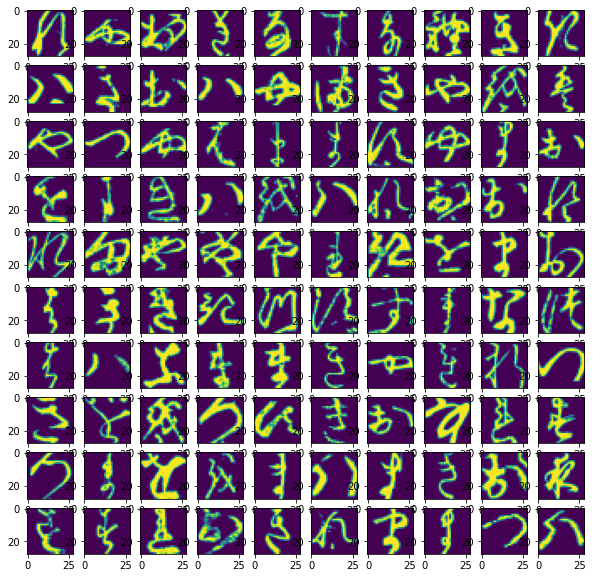

In [4]:
train = numpy.transpose(kmnist_train['imgs'], (2, 0, 1)).reshape(-1, 28, 28, 1)
train_y = kmnist_train['labels']
test = numpy.transpose(kmnist_test['imgs'], (2, 0, 1)).reshape(-1, 28, 28, 1)
test_y = kmnist_test['labels']

fig = plt.figure(figsize=[10, 10])
for i in range(100):
    ax = fig.add_subplot(10, 10, i + 1)
    ax.imshow(train[i,:,:,0])

### The Network

This is taken from the first week 4 lecture example.

I've defined the number of training epochs here as (essentially) a global constant. Note that I've run this on my GPU desktop. You may want to scale this back for your laptop, and in particular for the network at the very bottom of this if you plan to re-run it.

In [5]:
num_epochs = 25

def build_model(num_classes):
    # our model, input in an image shape
    inputs = keras.Input(shape=(28, 28, 1, ), name='img')
    # run pairs of conv layers, all 3s3 kernels
    x = layers.Conv2D(filters=8, kernel_size=(3,3), padding='same', activation='relu')(inputs)
    x = layers.Conv2D(filters=8, kernel_size=(3,3), padding='same', activation=None)(x)
    # batch normalisation, before the non-linearity
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    # spatial dropout, this will drop whole kernels, i.e. 20% of our 3x3 filters will be dropped out rather
    # than dropping out 20% of the invidual pixels
    x = layers.SpatialDropout2D(0.2)(x)
    # max pooling, 2x2, which will downsample the image
    x = layers.MaxPool2D(pool_size=(2, 2))(x)
    # rinse and repeat with 2D convs, batch norm, dropout and max pool
    x = layers.Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = layers.Conv2D(filters=16, kernel_size=(3,3), padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.SpatialDropout2D(0.2)(x)
    x = layers.MaxPool2D(pool_size=(2, 2))(x)
    # final conv2d, batch norm and spatial dropout
    x = layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.SpatialDropout2D(0.2)(x)

    # flatten layer
    x = layers.Flatten()(x)
    # we'll use a couple of dense layers here, mainly so that we can show what another dropout layer looks like 
    # in the middle
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(64, activation='relu')(x)
    # the output
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # build the model, and print a summary
    model_cnn = keras.Model(inputs=inputs, outputs=outputs, name='kmnist_cnn_model')
    
    return model_cnn

model_cnn = build_model(10)
model_cnn.summary()

Model: "kmnist_cnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 8)         80        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 8)         584       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 8)         32        
_________________________________________________________________
activation (Activation)      (None, 28, 28, 8)         0         
_________________________________________________________________
spatial_dropout2d (SpatialDr (None, 28, 28, 8)         0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 8)    

### Train the model

We're only going to train for 10 epochs. This could easily run longer, but for the sake of speed we'll keep it short.

In [6]:
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
history = model_cnn.fit(train, train_y,
                        batch_size=128,
                        epochs=num_epochs,
                        validation_data=(test, test_y))

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 13s 258us/sample - loss: 1.7803 - accuracy: 0.6837 - val_loss: 1.8228 - val_accuracy: 0.6366
Epoch 2/25
50000/50000 [==============================] - 12s 248us/sample - loss: 1.6833 - accuracy: 0.7782 - val_loss: 1.7483 - val_accuracy: 0.7122
Epoch 3/25
50000/50000 [==============================] - 13s 256us/sample - loss: 1.6522 - accuracy: 0.8093 - val_loss: 1.7206 - val_accuracy: 0.7399
Epoch 4/25
50000/50000 [==============================] - 13s 251us/sample - loss: 1.5868 - accuracy: 0.8756 - val_loss: 1.6319 - val_accuracy: 0.8283
Epoch 5/25
50000/50000 [==============================] - 12s 250us/sample - loss: 1.5510 - accuracy: 0.9111 - val_loss: 1.5827 - val_accuracy: 0.8785
Epoch 6/25
50000/50000 [==============================] - 13s 252us/sample - loss: 1.5244 - accuracy: 0.9372 - val_loss: 1.5619 - val_accuracy: 0.8976
Epoch 7/25
50000/50000 [====================

### Evaluate the Results

Borrowing again from the week 4 lecture example, and my eval model function.

10000/10000 - 1s - loss: 1.5276 - accuracy: 0.9336
Test loss: 1.5275881744384765
Test accuracy: 0.9336


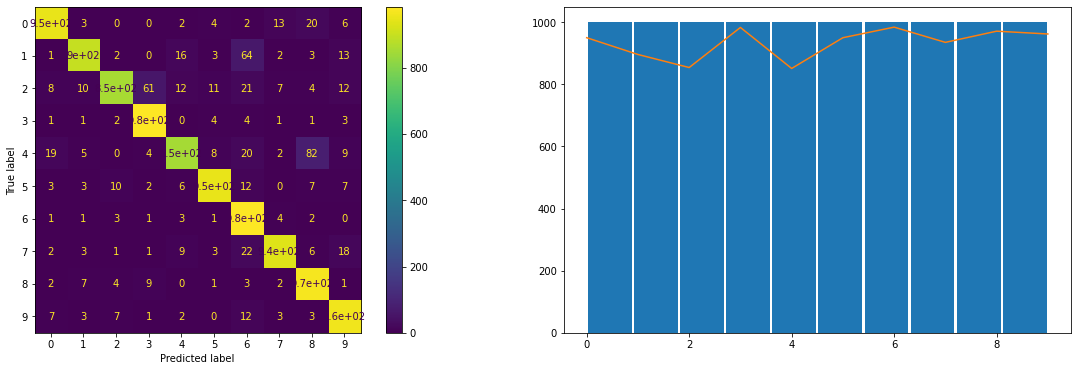

In [7]:
def eval_model(model, x_test, y_test):
    test_scores = model.evaluate(x_test, y_test, verbose=2)
    print('Test loss:', test_scores[0])
    print('Test accuracy:', test_scores[1])

    pred = model.predict(x_test);
    indexes = tf.argmax(pred, axis=1)

    cm = confusion_matrix(y_test, indexes)
    fig = plt.figure(figsize=[20, 6])
    ax = fig.add_subplot(1, 2, 1)
    c = ConfusionMatrixDisplay(cm, display_labels=range(10))
    c.plot(ax = ax)

    ax = fig.add_subplot(1, 2, 2)
    ax.hist(y_test, bins=len(numpy.diagonal(cm)), rwidth=0.95)
    ax.plot(numpy.diagonal(cm))

eval_model(model_cnn, test, test_y)

We can see a few things from the above training and evaluation:
* The model probably hasn't converged fully
* Performance is fairly consistent across all classes and classes are evenly distributed

## Part 2: K-MNIST 49
We'll repeat now using the 49 class version of the data. This largely follows the above part 1.

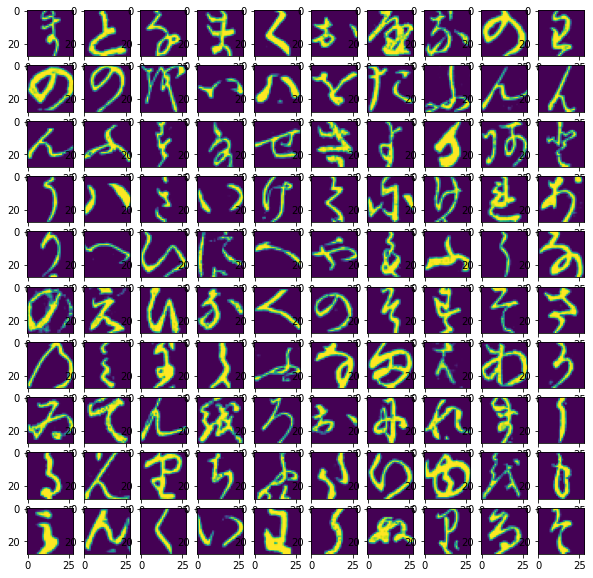

In [8]:
kmnist_train = scipy.io.loadmat('../../data/kmnist/kmnist49_train.mat')
kmnist_test = scipy.io.loadmat('../../data/kmnist/kmnist49_test.mat')
train = numpy.transpose(kmnist_train['imgs'], (2, 0, 1)).reshape(-1, 28, 28, 1)
train_y = kmnist_train['labels']
test = numpy.transpose(kmnist_test['imgs'], (2, 0, 1)).reshape(-1, 28, 28, 1)
test_y = kmnist_test['labels']

fig = plt.figure(figsize=[10, 10])
for i in range(100):
    ax = fig.add_subplot(10, 10, i + 1)
    ax.imshow(train[i,:,:,0])

### The Model
Exactly the same as last time - that's why I created a function for it. We're just going to increase the number of classes to 49 to match the different dataset.

In [9]:
model_cnn = build_model(49)
model_cnn.summary()

Model: "kmnist_cnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 8)         80        
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 8)         584       
_________________________________________________________________
batch_normalization_3 (Batch (None, 28, 28, 8)         32        
_________________________________________________________________
activation_3 (Activation)    (None, 28, 28, 8)         0         
_________________________________________________________________
spatial_dropout2d_3 (Spatial (None, 28, 28, 8)         0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 8)    

In [10]:
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
history = model_cnn.fit(train, train_y,
                        batch_size=128,
                        epochs=num_epochs,
                        validation_data=(test, test_y))

Train on 232365 samples, validate on 38547 samples
Epoch 1/25
232365/232365 [==============================] - 58s 249us/sample - loss: 3.5278 - accuracy: 0.4005 - val_loss: 3.4755 - val_accuracy: 0.4505
Epoch 2/25
232365/232365 [==============================] - 58s 249us/sample - loss: 3.4086 - accuracy: 0.5185 - val_loss: 3.4013 - val_accuracy: 0.5252
Epoch 3/25
232365/232365 [==============================] - 58s 250us/sample - loss: 3.3595 - accuracy: 0.5672 - val_loss: 3.3818 - val_accuracy: 0.5442
Epoch 4/25
232365/232365 [==============================] - 58s 250us/sample - loss: 3.3486 - accuracy: 0.5780 - val_loss: 3.3659 - val_accuracy: 0.5603
Epoch 5/25
232365/232365 [==============================] - 57s 247us/sample - loss: 3.3139 - accuracy: 0.6127 - val_loss: 3.3283 - val_accuracy: 0.5977
Epoch 6/25
232365/232365 [==============================] - 56s 243us/sample - loss: 3.2986 - accuracy: 0.6279 - val_loss: 3.3205 - val_accuracy: 0.6060
Epoch 7/25
232365/232365 [=====

38547/38547 - 3s - loss: 3.2308 - accuracy: 0.6954
Test loss: 3.230802689303244
Test accuracy: 0.69535893


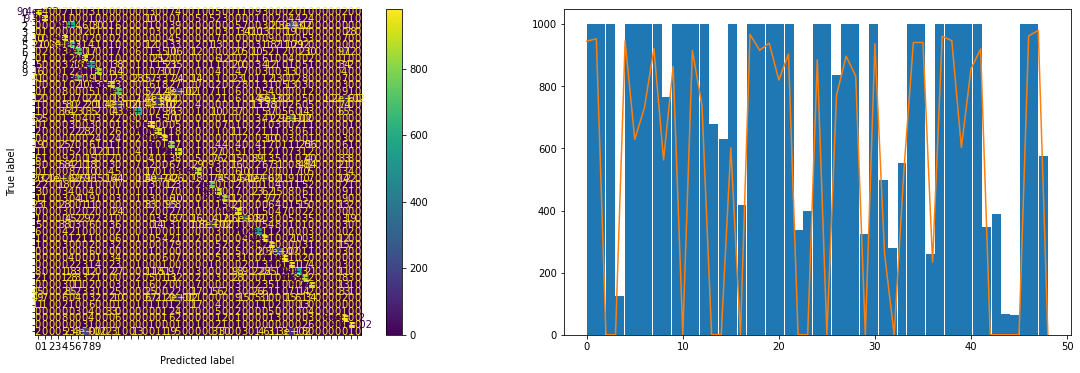

In [11]:
eval_model(model_cnn, test, test_y)

The model doesn't work that well.

We have massive class imbalance, and this doesn't help us. Let's adjust the class weights to try and compensate

### Adjusting Class Weights

We can use sklean to get the class weight for us

In [12]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 numpy.unique(train_y.flatten()),
                                                 train_y.flatten())
print(class_weights)

[ 0.79035714  0.79035714  0.79035714  6.10314396  0.79035714  0.79035714
  0.79035714  0.79035714  1.00597006  0.79035714  0.79035714  0.79035714
  0.79035714  1.13856971  1.22631054  0.79035714  1.84878864  0.79035714
  0.79035714  0.79035714  0.79035714  0.79035714  2.29866353  1.93477881
  0.79035714  0.79035714  0.92403407  0.79035714  0.79035714  2.37939933
  0.79035714  1.54971989  2.76026942  1.39721357  0.79035714  0.79035714
  2.96754872  0.79035714  0.79035714  0.79035714  0.79035714  0.79035714
  2.21699058  1.97836581 11.37204522 12.09730321  0.79035714  0.79035714
  1.34605247]


Comparing the class weights to the histogram above, we see that these make a lot of sense. Classes that were comparitively small have a high weight, those with lots of examples have a low weight.

We can pass that info directly to the model.fit call and use that to help train the model.

In [13]:
model_cnn = build_model(49)
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
history = model_cnn.fit(train, train_y,
                        batch_size=128,
                        epochs=num_epochs,
                        validation_data=(test, test_y), 
                        class_weight=class_weights)

Train on 232365 samples, validate on 38547 samples
Epoch 1/25
232365/232365 [==============================] - 56s 243us/sample - loss: 3.5239 - accuracy: 0.4042 - val_loss: 3.5068 - val_accuracy: 0.4194
Epoch 2/25
232365/232365 [==============================] - 56s 240us/sample - loss: 3.4212 - accuracy: 0.5058 - val_loss: 3.4637 - val_accuracy: 0.4619
Epoch 3/25
232365/232365 [==============================] - 56s 241us/sample - loss: 3.3658 - accuracy: 0.5613 - val_loss: 3.4040 - val_accuracy: 0.5220
Epoch 4/25
232365/232365 [==============================] - 56s 242us/sample - loss: 3.3323 - accuracy: 0.5944 - val_loss: 3.3743 - val_accuracy: 0.5518
Epoch 5/25
232365/232365 [==============================] - 56s 241us/sample - loss: 3.3043 - accuracy: 0.6223 - val_loss: 3.3301 - val_accuracy: 0.5966
Epoch 6/25
232365/232365 [==============================] - 56s 241us/sample - loss: 3.2691 - accuracy: 0.6575 - val_loss: 3.3168 - val_accuracy: 0.6095
Epoch 7/25
232365/232365 [=====

38547/38547 - 3s - loss: 3.2453 - accuracy: 0.6808
Test loss: 3.245301472549108
Test accuracy: 0.6808312


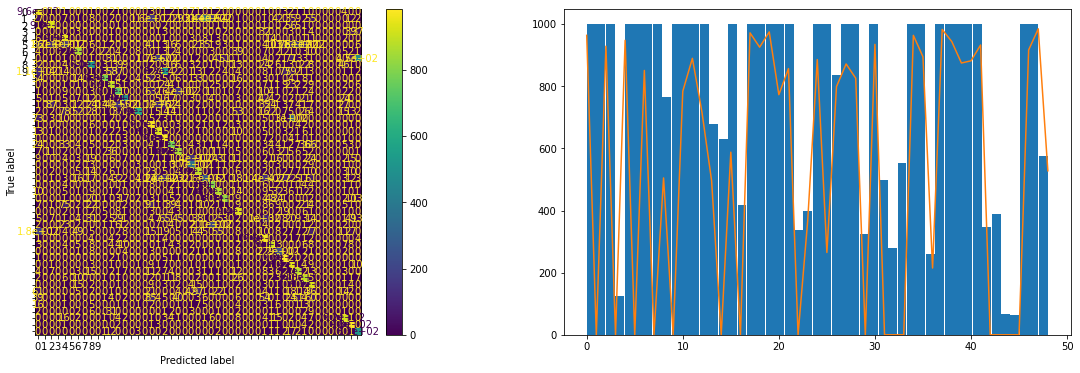

In [14]:
eval_model(model_cnn, test, test_y)

Training that network again, we see that our performance is still not that great, and has perhaps dropped a bit over what we had above. Remembering back to what we saw in week 3 with using class weights with SVMs, this is not surprising. By using the class weights we aim to improve performance for classes we have few instances of; at the possible cost of classes that we have lots of data of.

What this means is that we tend to make more errors on the really common classes, and because those classes are really common, we make more errors overall. Looking at our histogram, we see that for the really rare classes, we're still doing very badly. For the ones that we have a moderate amount of data for, we've typically improved a bit, and we've dropped a bit for some of the more common classes.

At this point it's worth pointing out that this is actually a fairly challenging dataset, with not only a decent number of classes (49), but also a lot of confusion between the classes. Telling these things apart is not that easy. We're also using a fairly simple network, which limits capacity. 

## Addendum

From above, we see a fairly substantial performance drop comapred to MATLAB. Why is this? It seems it has to do with the data representation and loss function.

MATLAB forces us to put data into a categorical data type, which gives us the one-hot vector format to match our output. Keras allows us to do this too, but also allows us to feed in the labels and use the loss function we've been using:
`keras.losses.SparseCategoricalCrossentropy(from_logits=True),`

This seems to work OK and in particular does pretty much what we'd expect for MNIST, FashionMNIST, and even KMINST-10, but is not quite as good as it should be for KMNIST-49. If we explicitly cast our data into the one-hot vector representation that we no we're going to use, we can actually get much better results, as we'll see below.

The first thing that we'll do is convert out labels, and helpfully there's a keras function for this.

In [15]:
from tensorflow.keras.utils import to_categorical

train_y = to_categorical(kmnist_train['labels'], 49)
test_y = to_categorical(kmnist_test['labels'], 49)

From this point we'll pretty much continue as per our last attempt, so we'll use class weights again.

In [16]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 numpy.unique(train_y.flatten()),
                                                 train_y.flatten())

The one change is to our loss. We now have a genuine one-hot representation, so we can use the standard categorical_crossentropy.

In [17]:
model_cnn = build_model(49)
model_cnn.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
history = model_cnn.fit(train, train_y,
                        batch_size=128,
                        epochs=num_epochs,
                        validation_data=(test, test_y), 
                        class_weight=class_weights)

Train on 232365 samples, validate on 38547 samples
Epoch 1/25
232365/232365 [==============================] - 59s 253us/sample - loss: 1.2191 - accuracy: 0.6762 - val_loss: 0.7108 - val_accuracy: 0.8080
Epoch 2/25
232365/232365 [==============================] - 58s 250us/sample - loss: 0.5538 - accuracy: 0.8483 - val_loss: 0.5277 - val_accuracy: 0.8587
Epoch 3/25
232365/232365 [==============================] - 58s 251us/sample - loss: 0.4304 - accuracy: 0.8822 - val_loss: 0.4167 - val_accuracy: 0.8878
Epoch 4/25
232365/232365 [==============================] - 58s 251us/sample - loss: 0.3708 - accuracy: 0.8980 - val_loss: 0.3667 - val_accuracy: 0.9051
Epoch 5/25
232365/232365 [==============================] - 59s 252us/sample - loss: 0.3312 - accuracy: 0.9085 - val_loss: 0.3370 - val_accuracy: 0.9113
Epoch 6/25
232365/232365 [==============================] - 58s 251us/sample - loss: 0.3075 - accuracy: 0.9150 - val_loss: 0.3142 - val_accuracy: 0.9170
Epoch 7/25
232365/232365 [=====

We need to modify our eval_model function slightly to deal with the different data type for our test labels.

38547/38547 - 3s - loss: 0.2285 - accuracy: 0.9446
Test loss: 0.2285040391557707
Test accuracy: 0.9446131


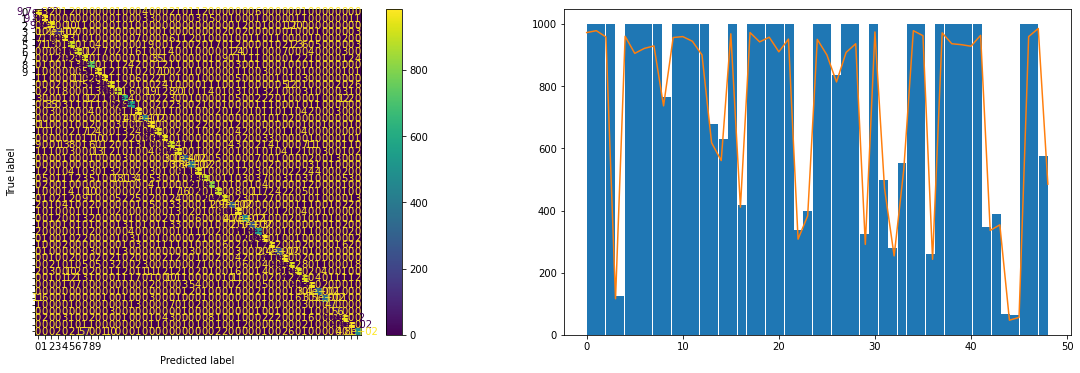

In [19]:
def eval_model(model, x_test, y_test):
    test_scores = model.evaluate(x_test, y_test, verbose=2)
    print('Test loss:', test_scores[0])
    print('Test accuracy:', test_scores[1])

    pred = model.predict(x_test);
    indexes = tf.argmax(pred, axis=1)
    gt_idx = tf.argmax(y_test, axis=1)

    cm = confusion_matrix(gt_idx, indexes)
    fig = plt.figure(figsize=[20, 6])
    ax = fig.add_subplot(1, 2, 1)
    c = ConfusionMatrixDisplay(cm, display_labels=range(10))
    c.plot(ax = ax)

    ax = fig.add_subplot(1, 2, 2)
    ax.hist(gt_idx, bins=len(numpy.diagonal(cm)), rwidth=0.95)
    ax.plot(numpy.diagonal(cm))

eval_model(model_cnn, test, test_y)

The end result if that our acccuracy is much better - nothing has changed, except the loss formulation. 